# Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Flags

In [27]:
zmuv = False
cropping = True

# 1. Pre-Processing

1. Read Image in grayscale
2. Convert to float64
3. Normalize pixel values to range [0, 1]

4. Divide picture into green, red and blue channels

### 1. Read Image in Grayscale

(9627, 3702)


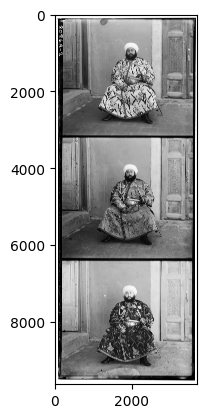

In [28]:
image_name = 'images/emir.tif'

image = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
print(image.shape)

plt.imshow(image, cmap='gray')

### 2. Convert to float64 and 3. Normalize to range [0, 1]

In [29]:
float_image = image.astype(np.float64) / 255.0

### 3. Zero-mean, unit-variance (ZMUV)

In [30]:
# float_image = (float_image - float_image.mean()) / (float_image.std() + 1e-8)

# plt.imshow(float_image, cmap='gray')

### 4. Divide Image into Red, Green and Blue Images

In [46]:
h = float_image.shape[0] // 3

img_b = float_image[0:h, :]
img_g = float_image[h:2*h, :]
img_r = float_image[2*h:3*h, :]

blue = image[0:h, :]
green = image[h:2*h, :]
red = image[2*h:3*h, :]

print("Shapes: \n", img_b.shape,"\n", img_g.shape,"\n", img_r.shape)
print("Shapes: \n", blue.shape,"\n", green.shape,"\n", red.shape)

Shapes: 
 (3209, 3702) 
 (3209, 3702) 
 (3209, 3702)
Shapes: 
 (3209, 3702) 
 (3209, 3702) 
 (3209, 3702)


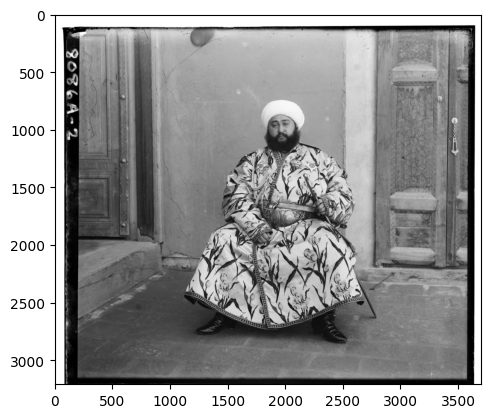

In [32]:
plt.imshow(img_b, cmap='gray')

# 2. Alignment Pre-Processing

1. Crop channels by 10% to remove noisy borders

### 1. Crop Channels by 10%

In [33]:
def crop_frac(img, frac=0.10):
    """Return a centered crop that removes `frac` of the size from each side."""
    H, W = img.shape
    y0, y1 = int(frac*H), int((1-frac)*H)
    x0, x1 = int(frac*W), int((1-frac)*W)
    return img[y0:y1, x0:x1]

In [34]:
if cropping:
    crop_b = crop_frac(img_b, 0.10)
    crop_g = crop_frac(img_g, 0.10)
    crop_r = crop_frac(img_r, 0.10)

    print("Shapes: \n", crop_b.shape,"\n", crop_g.shape,"\n", crop_r.shape)
else:
    crop_b = img_b
    crop_g = img_g
    crop_r = img_r

Shapes: 
 (2568, 2961) 
 (2568, 2961) 
 (2568, 2961)


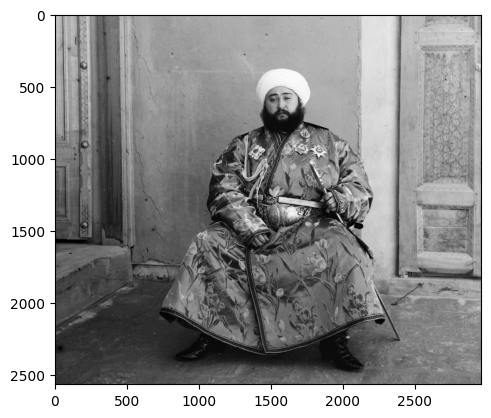

In [35]:
plt.imshow(crop_g, cmap='gray')

### 2. Zero-mean, unit-variance (ZMUV)



In [36]:
if zmuv:
    crop_b = (crop_b - crop_b.mean()) / (crop_b.std() + 1e-8)
    crop_g = (crop_g - crop_g.mean()) / (crop_g.std() + 1e-8)
    crop_r = (crop_r - crop_r.mean()) / (crop_r.std() + 1e-8)

    plt.imshow(crop_g, cmap='gray')

### 3. Sobel Gradients (Edge comparison)

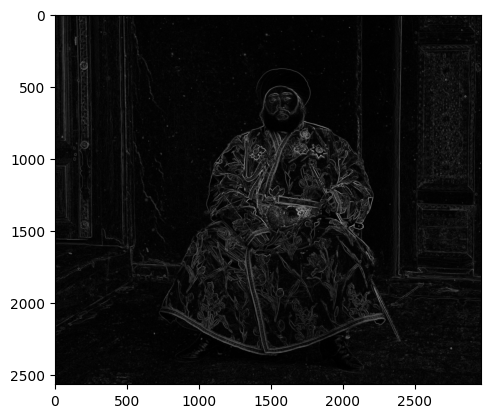

In [37]:
def sobel_mag(img, blur_ksize=5, sobel_ksize=3, eps=1e-8):
    """
    img: HxW float in [0,1]
    returns: HxW float in [0,1] (edge strength)
    """
    f = img.astype(np.float32)
    if blur_ksize:
        f = cv2.GaussianBlur(f, (blur_ksize, blur_ksize), 0)
    gx = cv2.Sobel(f, cv2.CV_32F, 1, 0, ksize=sobel_ksize)
    gy = cv2.Sobel(f, cv2.CV_32F, 0, 1, ksize=sobel_ksize)
    mag = np.sqrt(gx*gx + gy*gy)

    # Normalize to [0,1] for stable scoring
    mmin, mmax = mag.min(), mag.max()
    mag = (mag - mmin) / (mmax - mmin + eps)
    return mag

crop_b = sobel_mag(crop_b)
crop_g = sobel_mag(crop_g)
crop_r = sobel_mag(crop_r)

plt.imshow(crop_g, cmap='gray')

# 3. Image Alignment
1. Similarity Functions
1.1 Euclidian Distance Function
2. Alignment Off-set Function
3. Align Image Function

### 1.1 Euclidean Distance Function

In [38]:
def euclidean_distance(base, shifted):
    """Compute Euclidean distance (L2 norm) between two images."""
    return np.sqrt(np.sum((base - shifted) ** 2))

### 2. Alignment Off-set Function

In [39]:
def align_images_ed(base_img, img_to_align, search_range=15): # search_range in pixels
    """
    Align img_to_align to base_img using exhaustive search and Euclidean distance.
    Returns the best displacement (dy, dx) and the aligned image.
    """
    best_score = float('inf')
    best_disp = (0, 0)

    for dy in range(-search_range, search_range + 1):
        for dx in range(-search_range, search_range + 1):
            shifted = np.roll(np.roll(img_to_align, dy, axis=0), dx, axis=1)
            score = euclidean_distance(base_img, shifted)
            if score < best_score:
                best_score = score
                best_disp = (dy, dx)

    aligned = np.roll(np.roll(img_to_align, best_disp[0], axis=0),
                      best_disp[1], axis=1)
    return best_disp, aligned

G shift (dy, dx): (10, 10)
R shift (dy, dx): (10, 9)


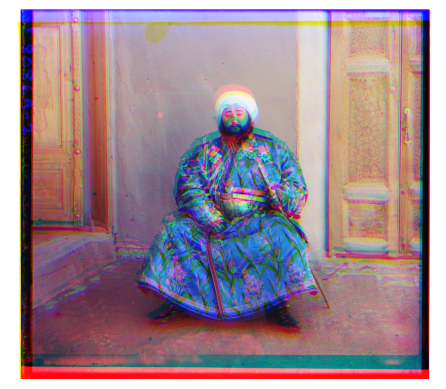

In [40]:
def apply_shift(img, dy, dx):
    return np.roll(np.roll(img, dy, axis=0), dx, axis=1)

g_disp, g_aligned = align_images_ed(crop_b, crop_g, search_range=10)
r_disp, r_aligned = align_images_ed(crop_b, crop_r, search_range=10)

print("G shift (dy, dx):", g_disp)
print("R shift (dy, dx):", r_disp)

# 2) Apply those SAME shifts to the ORIGINAL full images
img_g_aligned = apply_shift(img_g, g_disp[0], g_disp[1])
img_r_aligned = apply_shift(img_r, r_disp[0], r_disp[1])

# --- Stack and display (RGB = [R, G, B]) ---
rgb = np.dstack([img_r_aligned, img_g_aligned, img_b])  # already in [0,1]

plt.imshow(np.clip(rgb, 0, 1))
plt.axis('off')
plt.show()

## 4. Image Alignment, with Downscaling and Image Pyramids
1. Downscale Function, with Factor 2
2. Image-Pyramid Alignment Function


### 1. Downscale Image Function, Factor 2

In [41]:
def downscale_by_2(img, factor=2):
    """
    Downscale an image by factor 2 using block averaging.
    Works for grayscale (H,W) or color (H,W,C).
    """
    h, w = img.shape[:2]

    # make dimensions divisible by 2
    h2, w2 = h - (h % factor), w - (w % factor)
    img_cropped = img[:h2, :w2]

    if img.ndim == 2:  # grayscale
        return img_cropped.reshape(h2//factor, factor, w2//factor, factor).mean(axis=(1, 3))
    else:  # color image
        return img_cropped.reshape(h2//factor, factor, w2//factor, factor, img.shape[2]).mean(axis=(1, 3))

Original shape: (2568, 2961)
Downscaled shape: (1284, 1480)


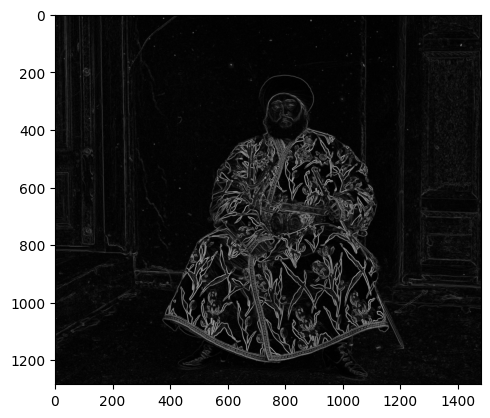

In [42]:
out = downscale_by_2(crop_b, 2)

print("Original shape:", crop_b.shape)
print("Downscaled shape:", out.shape)

plt.imshow(out, cmap='gray')

### 2. Image-Pyramid Alignment Function (Using Euclidian Distance)

In [43]:
def align_pyramid_ed(base, mov, depth=5, search_range=10):
    """
    Recursively align `mov` to `base` using a pyramid of `depth` levels.
    - At the coarsest level, run your align_images_ed.
    - Propagate shift upward (×2) and refine at each finer level by re-running
      align_images_ed around the pre-shifted image (same search_range).
    Returns: ((dy, dx), aligned_image_at_full_resolution)
    """
    base = base.astype(np.float64)
    mov  = mov.astype(np.float64)

    if depth <= 1:
        # coarsest level: plain exhaustive ED search
        return align_images_ed(base, mov, search_range=search_range)

    # 1) downsample both by 2 and recurse
    base_small = downscale_by_2(base, factor=2)
    mov_small  = downscale_by_2(mov,  factor=2)

    (dy_small, dx_small), _ = align_pyramid_ed(
        base_small, mov_small, depth=depth-1, search_range=search_range
    )

    # 2) project coarse shift up to this level
    dy0, dx0 = int(dy_small)*2, int(dx_small)*2

    # 3) pre-shift by the projected offset, then refine locally
    mov_pre = apply_shift(mov, dy0, dx0)
    (dy_ref, dx_ref), _ = align_images_ed(base, mov_pre, search_range=search_range)

    # 4) combine shifts and return aligned full-res image
    dy, dx = dy0 + dy_ref, dx0 + dx_ref
    aligned_full = apply_shift(mov, dy, dx)
    return (dy, dx), aligned_full


G shift (dy, dx): (49, 23)
R shift (dy, dx): (107, 40)
(3209, 3702, 3)


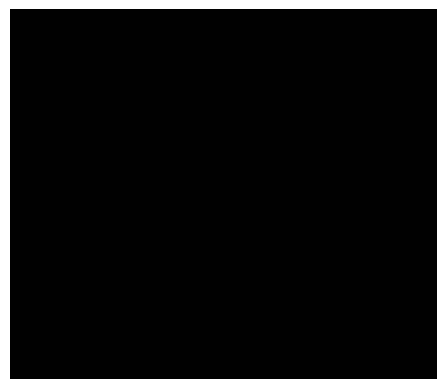

In [ ]:
(g_shift, g_aligned_crop) = align_pyramid_ed(crop_b, crop_g, depth=5, search_range=5)
(r_shift, r_aligned_crop) = align_pyramid_ed(crop_b, crop_r, depth=5, search_range=5)

print("G shift (dy, dx):", g_shift)
print("R shift (dy, dx):", r_shift)

# Apply the same shifts to the ORIGINAL, full images
img_g_aligned = apply_shift(green, g_shift[0], g_shift[1])
img_r_aligned = apply_shift(red, r_shift[0], r_shift[1])


# Stack (R, G, B) and display
rgb_full = np.dstack([img_r_aligned, img_g_aligned, blue])  # already float in [0,1]

print(rgb_full.shape)

plt.imshow(np.clip(rgb_full, 0, 1))
plt.axis('off'); plt.show()

In [45]:
raise Exception("Error thrown as requested")

Exception: Error thrown as requested

## 5. Bells & Whistles

0. Normalization Pre-Processing for different brightness levels
1. Automatic Cropping (Already done (10%))
2. Automatic Contrasting (Rescale, so: Darkest Pixel is zero and brightest pixel is 1)
3. Automatic white balance
4. Better color mapping
5. Better Features: Alignment on gradients or edges, rather than rgb

Original img_b shape: (3209, 3702)
Downscaled img_b shape: (100, 115)


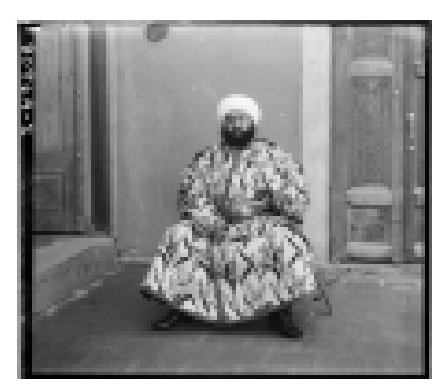

In [ ]:
# Downsample img_b by factor of 5 using downscale_by_2 function
img_b_downscaled = img_b
for i in range(5):
    img_b_downscaled = downscale_by_2(img_b_downscaled)

print("Original img_b shape:", img_b.shape)
print("Downscaled img_b shape:", img_b_downscaled.shape)
plt.imshow(img_b_downscaled, cmap='gray')
plt.axis('off')
plt.show()


## Read in all the images

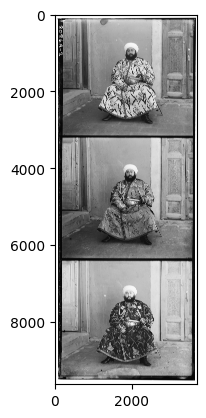

In [ ]:
tif_image = cv2.imread('images/emir.tif')

plt.imshow(tif_image)

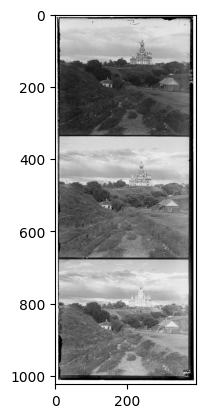

In [ ]:
imname = 'images/cathedral.jpg'

img = cv2.imread(imname)

plt.imshow(img)

In [ ]:
img.shape

(1024, 390, 3)

## Slice Images

In [ ]:
slice = int(img.shape[0]/3)

slice

341

In [ ]:
slice_tif = int(tif_image.shape[0] / 3)

slice_tif

3209

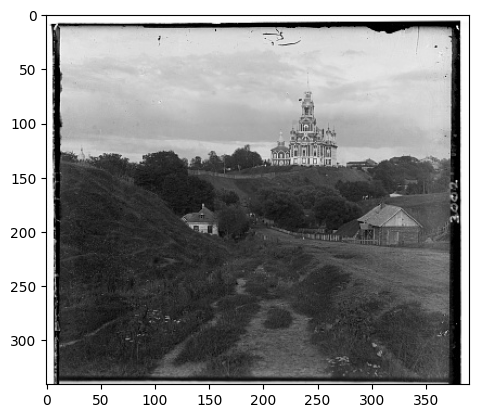

In [ ]:
img_b = img[:slice, :, :]

plt.imshow(img_b)

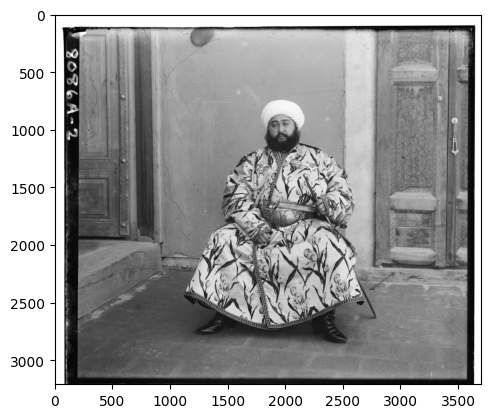

In [ ]:
img_b_tif = tif_image[:slice_tif, :, :]

plt.imshow(img_b_tif)

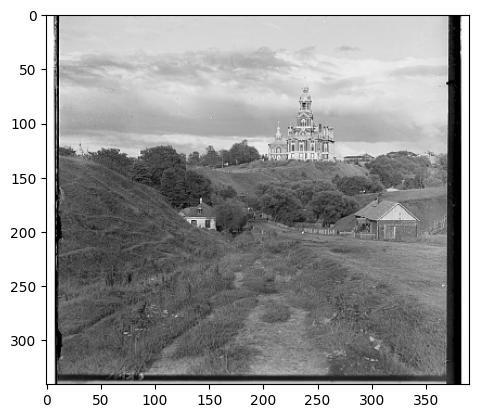

In [ ]:
img_g = img[slice:2*slice, :, :]

plt.imshow(img_g)

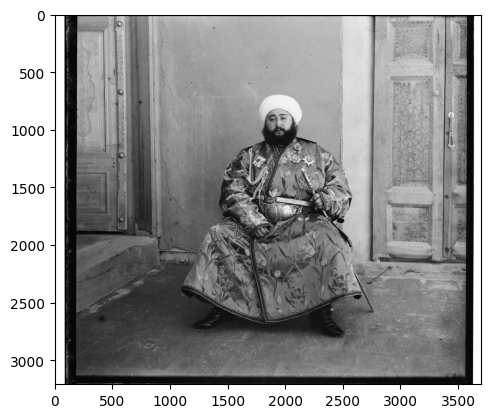

In [ ]:
img_g_tif = tif_image[slice_tif:2*slice_tif, :, :]

plt.imshow(img_g_tif)

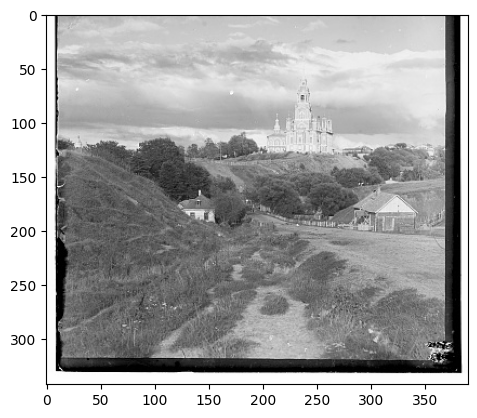

In [ ]:
img_r = img[2*slice:, :, :]

plt.imshow(img_r)

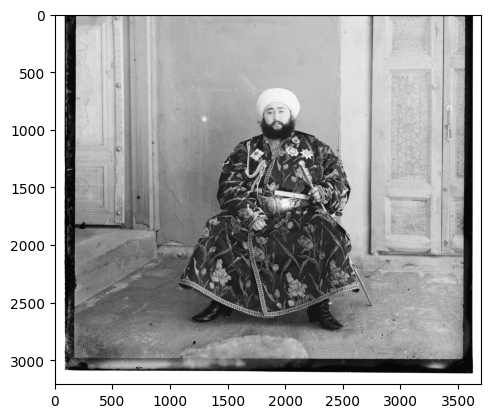

In [ ]:
img_r_tif = tif_image[2*slice_tif:, :, :]

plt.imshow(img_r_tif)

In [ ]:
img_r.shape

img_r = img_r[:341, :, :]

img_r.shape

(341, 390, 3)

In [ ]:
print(img_b.shape)
print(img_g.shape)
print(img_r.shape)

(341, 390, 3)
(341, 390, 3)
(341, 390, 3)


In [ ]:
print(img_b_tif.shape)
print(img_g_tif.shape)
print(img_r_tif.shape)

(3209, 3702, 3)
(3209, 3702, 3)
(3209, 3702, 3)


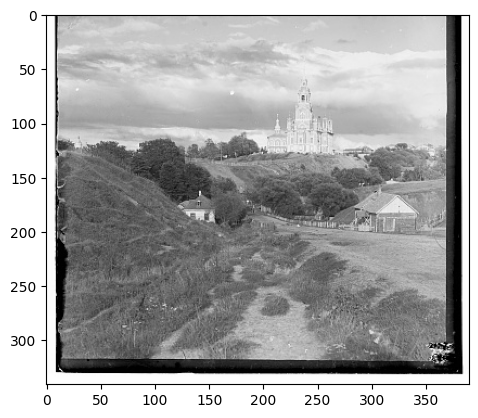

In [ ]:
plt.imshow(img_r)

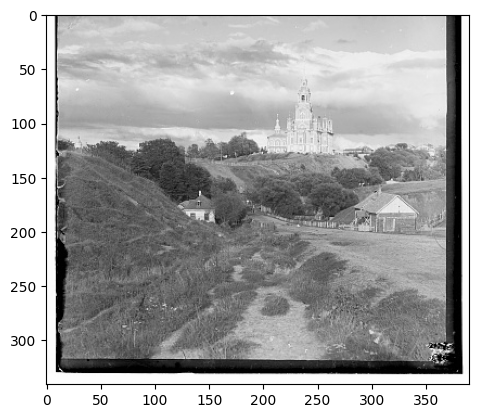

In [ ]:
plt.imshow(img_r[:, :, 0], cmap='gray')

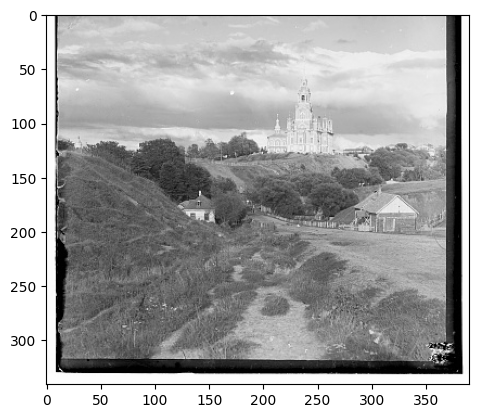

In [ ]:
plt.imshow(img_r[:, :, 1], cmap='gray')

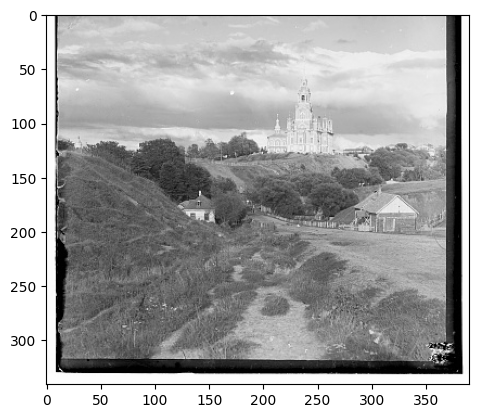

In [ ]:
plt.imshow(img_r[:, :, 2], cmap='gray')

### Next Steps: 
1. Align Images
2. Stack Images

## Scale down Images (H, W, 3) -> (H, W)

In [ ]:
img_b_1 = img_b[:, :, 0]
img_g_1 = img_g[:, :, 0]
img_r_1 = img_r[:, :, 0]


print(img_b_1.shape)
print(img_g_1.shape)
print(img_r_1.shape)

(341, 390)
(341, 390)
(341, 390)


In [ ]:
img_b_tif_1 = img_b_tif[:, :, 0]
img_g_tif_1 = img_g_tif[:, :, 0]
img_r_tif_1 = img_r_tif[:, :, 0]

print(img_b_tif_1.shape)
print(img_g_tif_1.shape)
print(img_r_tif_1.shape)


(3209, 3702)
(3209, 3702)
(3209, 3702)


## Align Images

### Stack Images without alignment ("Stupid" Version)

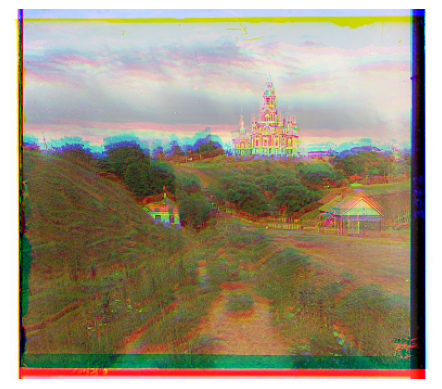

In [ ]:
aligned_images = np.dstack([img_r_1, img_g_1, img_b_1])

plt.imshow(aligned_images)
plt.axis('off')
plt.show()

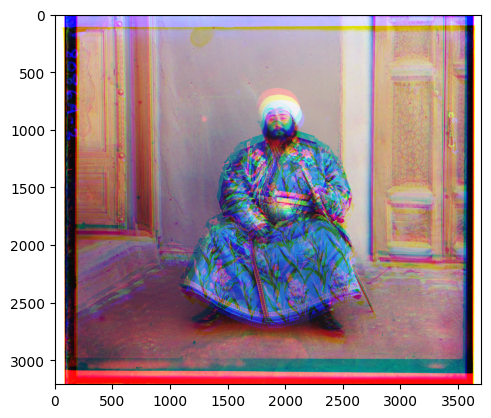

In [ ]:
aligned_images_tif = np.dstack([img_r_tif_1, img_g_tif_1, img_b_tif_1])

plt.imshow(aligned_images_tif)

### Euclidian Distance

In [ ]:
def align_images_ed(base_img, img_to_align, search_range=15):
    best_score = float('inf')
    best_disp = (0, 0)

    for dy in range(-search_range, search_range + 1):
        for dx in range(-search_range, search_range + 1):
            shifted = np.roll(np.roll(img_to_align, dy, axis=0), dx, axis=1)
            score = np.sum((base_img - shifted)**2)
            if score < best_score:
                best_score = score
                best_disp = (dy, dx)

    aligned = np.roll(np.roll(img_to_align, best_disp[0], axis=0),
                      best_disp[1], axis=1)
    return best_disp, aligned

### NCC

In [ ]:
import numpy as np

def ncc(a, b, eps=1e-9):
    a0 = a - a.mean(); b0 = b - b.mean()
    return (a0*b0).sum() / (np.sqrt((a0*a0).sum())*np.sqrt((b0*b0).sum()) + eps)

def overlap_views(base, mov, dy, dx):
    """Return overlapping (base_patch, mov_patch) for shift (dy, dx) with no wraparound."""
    H, W = base.shape
    y0b = max(0,  dy);  y1b = min(H, H+dy)
    x0b = max(0,  dx);  x1b = min(W, W+dx)

    y0m = max(0, -dy);  y1m = min(H, H-dy)
    x0m = max(0, -dx);  x1m = min(W, W-dx)

    return base[y0b:y1b, x0b:x1b], mov[y0m:y1m, x0m:x1m]

def align_images_ncc_overlap(base_img, img_to_align, search_range=15):
    """Like your NCC aligner, but evaluates NCC on the true overlap (no wrap)."""
    base = base_img.astype(np.float32)
    mov  = img_to_align.astype(np.float32)

    best_score = -np.inf
    best_disp  = (0, 0)

    for dy in range(-search_range, search_range+1):
        for dx in range(-search_range, search_range+1):
            b, m = overlap_views(base, mov, dy, dx)
            if b.size < 1000:    # tiny overlaps are unstable—skip
                continue
            score = ncc(b, m)
            if score > best_score:
                best_score, best_disp = score, (dy, dx)

    # Apply best shift *once* to the full image (roll is fine for the final shift)
    aligned = np.roll(np.roll(img_to_align, best_disp[0], 0), best_disp[1], 1)
    return best_disp, aligned


## Stack Images

### Align and Stack Euclidian Distance

G shift (dy, dx): (3, 0)
R shift (dy, dx): (8, -1)


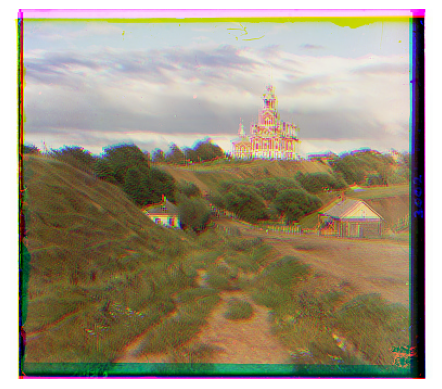

In [ ]:
g_disp, img_g_aligned = align_images_ed(img_b_1, img_g_1, 100)
r_disp, img_r_aligned = align_images_ed(img_b_1, img_r_1, 100)

print("G shift (dy, dx):", g_disp)
print("R shift (dy, dx):", r_disp)

# Stack into RGB color image
aligned_color = np.dstack([img_r_aligned, img_g_aligned, img_b_1])

import matplotlib.pyplot as plt
plt.imshow(aligned_color)
plt.axis('off')
plt.show()

G shift (dy, dx): (10, 10)
R shift (dy, dx): (9, 10)


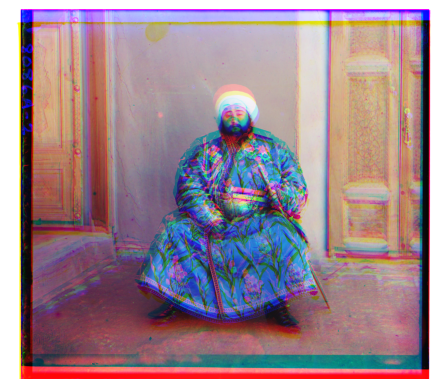

In [ ]:
g_disp, img_g_aligned = align_images_ed(img_b_tif_1, img_g_tif_1, 10)
r_disp, img_r_aligned = align_images_ed(img_b_tif_1, img_r_tif_1, 10)

print("G shift (dy, dx):", g_disp)
print("R shift (dy, dx):", r_disp)

# Stack into RGB color image
aligned_color = np.dstack([img_r_aligned, img_g_aligned, img_b_tif_1])

import matplotlib.pyplot as plt
plt.imshow(aligned_color)
plt.axis('off')
plt.show()

### Align and Stack NCC

G shift (dy, dx): (12, -1)
R shift (dy, dx): (14, -1)


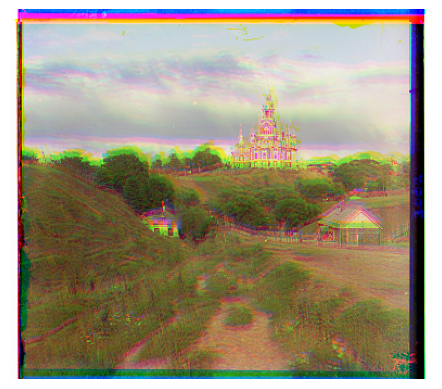

In [ ]:
g_disp, img_g_aligned = align_images_ncc_overlap(img_b_1, img_g_1, 15)
r_disp, img_r_aligned = align_images_ncc_overlap(img_b_1, img_r_1, 15)

print("G shift (dy, dx):", g_disp)
print("R shift (dy, dx):", r_disp)

# Stack into RGB color image
aligned_color = np.dstack([img_r_aligned, img_g_aligned, img_b_1])

import matplotlib.pyplot as plt
plt.imshow(aligned_color)
plt.axis('off')
plt.show()

In [ ]:
g_disp, img_g_aligned = align_images_ncc_overlap(img_b_tif_1, img_g_tif_1, 15)
r_disp, img_r_aligned = align_images_ncc_overlap(img_b_tif_1, img_r_tif_1, 15)

print("G shift (dy, dx):", g_disp)
print("R shift (dy, dx):", r_disp)

# Stack into RGB color image
aligned_color = np.dstack([img_r_aligned, img_g_aligned, img_b_tif_1])

import matplotlib.pyplot as plt
plt.imshow(aligned_color)
plt.axis('off')
plt.show()

KeyboardInterrupt: 

## Downscale

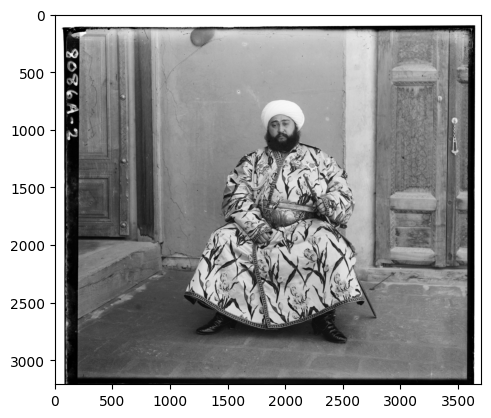

In [ ]:
img_b_tif_1.shape


plt.imshow(img_b_tif_1, cmap='gray')

In [ ]:
def downscale_by_factor(img, factor=2):
    """
    Downscale image by integer factor using block averaging.
    If dimensions are not divisible by factor, crops the extra rows/cols.
    """
    h, w = img.shape[:2]
    h2, w2 = h - (h % factor), w - (w % factor)   # make divisible
    img_cropped = img[:h2, :w2]

    # reshape and average over blocks
    if img_cropped.ndim == 2:  # grayscale
        return img_cropped.reshape(h2//factor, factor, w2//factor, factor).mean(axis=(1, 3))
    else:  # color image, keep channels
        return img_cropped.reshape(h2//factor, factor, w2//factor, factor, -1).mean(axis=(1, 3))


(100, 115)


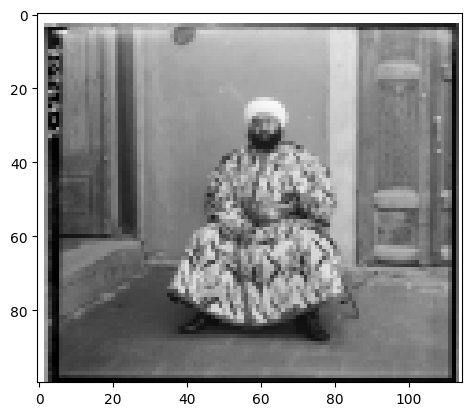

In [ ]:
def recursive_downscale(img, factor=2, starting_scale=100):
    out = img.copy()
    while out.shape[0] > starting_scale:
        out = downscale_by_factor(out, factor)
    return out

out = recursive_downscale(img_b_tif_1, starting_scale=100) # starting scale == pixel size
plt.imshow(out, cmap='gray')
print(out.shape)

### Image Pyramid Use

In [ ]:
import numpy as np

# --- you already have these ---
# def align_images_ncc(base_img, img_to_align, search_range=15): ...
# def recursive_downscale(img, factor=2, starting_scale=100): ...
# def downscale_by_factor(img, factor=2): ...   # used by recursive_downscale

def _down_n_times(img, times, factor=2):
    """Downscale 'times' times by 'factor' using your downscaler."""
    out = img
    for _ in range(times):
        out = downscale_by_factor(out, factor)
    return out

def _levels_used(img, factor=2, starting_scale=100):
    """How many times recursive_downscale would have been applied."""
    h = img.shape[0]
    L = 0
    while h > starting_scale:
        h //= factor
        L += 1
    return L

def align_pyramid_with_your_ncc(base, mov, factor=2, starting_scale=100,
                                coarse_search=8, refine_search=4):
    """
    Coarse→fine alignment using *your* NCC function and *your* downscaler.
    Returns (dy, dx) at full resolution and the aligned full-res image.
    """
    # Ensure 2D float arrays
    base = np.asarray(base).astype(np.float32)
    mov  = np.asarray(mov).astype(np.float32)
    if base.ndim == 3 and base.shape[-1] == 3:
        base = 0.2126*base[...,0] + 0.7152*base[...,1] + 0.0722*base[...,2]
    if mov.ndim  == 3 and mov.shape[-1]  == 3:
        mov  = 0.2126*mov[...,0]  + 0.7152*mov[...,1]  + 0.0722*mov[...,2]

    # 1) figure out how many pyramid levels your recursive_downscale will make
    L = _levels_used(base, factor=factor, starting_scale=starting_scale)

    # 2) align at coarsest level (downscaled L times)
    base_coarse = _down_n_times(base, L, factor)
    mov_coarse  = _down_n_times(mov,  L, factor)
    (dy, dx), _ = align_images_ncc_overlap(base_coarse, mov_coarse, search_range=coarse_search)

    # 3) walk up to finer levels: scale shift and refine locally with small search
    for k in range(L-1, -1, -1):
        # project shift to next finer level
        dy *= factor; dx *= factor

        # build images at this level on-the-fly (downscale k times)
        base_k = _down_n_times(base, k, factor)
        mov_k  = _down_n_times(mov,  k, factor)

        # pre-apply current estimate, then refine around it with your NCC
        mov_k_pre = np.roll(np.roll(mov_k, dy, axis=0), dx, axis=1)
        (ddy, ddx), _ = align_images_ncc_overlap(base_k, mov_k_pre, search_range=refine_search)
        dy += ddy; dx += ddx

    # 4) apply final shift at full resolution
    aligned_full = np.roll(np.roll(mov, dy, axis=0), dx, axis=1)
    return (dy, dx), aligned_full


G shift (dy, dx): (12, 8)
R shift (dy, dx): (110, 17)


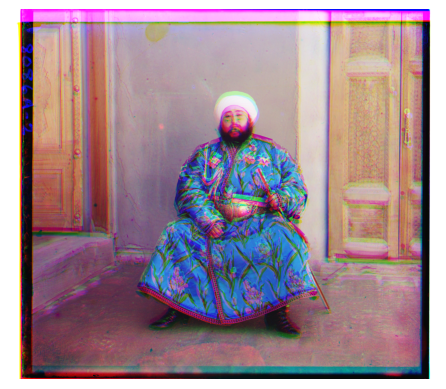

In [ ]:
# b, g, r are your channel tiles (2D or (H,W,3); any dtype). This wrapper handles it.
(g_shift, g_aligned) = align_pyramid_with_your_ncc(img_b_tif_1, img_g_tif_1,
                                                   factor=2, starting_scale=100,
                                                   coarse_search=8, refine_search=4)
(r_shift, r_aligned) = align_pyramid_with_your_ncc(img_b_tif_1, img_r_tif_1,
                                                   factor=2, starting_scale=100,
                                                   coarse_search=8, refine_search=4)

print("G shift (dy, dx):", g_shift)
print("R shift (dy, dx):", r_shift)

rgb = np.dstack([r_aligned, g_aligned, np.asarray(img_b_tif_1, dtype=np.float32)])
# Display correctly (scale if 0..255 or 0..65535)
rgb_vis = (rgb / rgb.max()).astype(np.float32)
import matplotlib.pyplot as plt
plt.imshow(rgb_vis); plt.axis('off'); plt.show()


## Image Pyramid

In [ ]:
def roll2(img, dy, dx):
    """np.roll with (dy, dx) convention."""
    return np.roll(np.roll(img, dy, axis=0), dx, axis=1)

def down2_mean(img):
    """
    Downscale by factor 2 via 2x2 block average (anti-aliased).
    If shape is odd, trim the last row/col.
    """
    h, w = img.shape
    h2, w2 = h - (h % 2), w - (w % 2)
    img2 = img[:h2, :w2]
    # reshape into (h/2, 2, w/2, 2) and average on the small dims
    return img2.reshape(h2//2, 2, w2//2, 2).mean(axis=(1, 3))

def ssd_score(a, b):
    """Smaller is better."""
    d = a - b
    return np.sum(d * d)

def ncc_score(a, b, eps=1e-9):
    """
    Normalized cross-correlation. Larger is better.
    Assumes a, b are float arrays of same shape.
    """
    a0 = a - a.mean()
    b0 = b - b.mean()
    denom = np.sqrt((a0*a0).sum()) * np.sqrt((b0*b0).sum()) + eps
    return (a0 * b0).sum() / denom

# ---------------------------
# Single-scale exhaustive search
# ---------------------------

def align_single_scale(base, mov, search_range=15, metric='ncc'):
    """
    Exhaustive integer search in [-search_range, +search_range] for (dy, dx).
    metric: 'ncc' (maximize) or 'ssd' (minimize).
    Returns (dy, dx), aligned_image
    """
    base = base.astype(np.float32)
    mov  = mov.astype(np.float32)

    if metric == 'ncc':
        best_score = -np.inf
        better = lambda s, b: s > b
    else:  # 'ssd'
        best_score = np.inf
        better = lambda s, b: s < b

    best = (0, 0)

    for dy in range(-search_range, search_range + 1):
        for dx in range(-search_range, search_range + 1):
            shifted = roll2(mov, dy, dx)
            score = ncc_score(base, shifted) if metric == 'ncc' else ssd_score(base, shifted)
            if better(score, best_score):
                best_score = score
                best = (dy, dx)

    aligned = roll2(mov, *best)
    return best, aligned

# ---------------------------
# Recursive pyramid alignment
# ---------------------------

def align_pyramid_recursive(base, mov, levels=None, metric='ncc',
                            coarse_search=5, refine_search=3):
    """
    Coarse-to-fine recursive alignment.
    - If 'levels' is None, it builds as many 2x downsamples as possible until min(H,W) < 100.
    - At the coarsest level: run single-scale search with 'coarse_search'.
    - On the way back up: double the coarse shift and refine locally with 'refine_search'.
    Returns (dy, dx), aligned_image
    """
    base = base.astype(np.float32)
    mov  = mov.astype(np.float32)

    # Decide how many levels if not provided.
    if levels is None:
        # Build levels until the smallest side would drop below ~100
        L = 0
        h, w = base.shape
        while min(h, w) >= 200:  # target coarsest size ~100 after L downsamples
            h //= 2; w //= 2; L += 1
        levels = L

    # Base case: bottom of the pyramid
    if levels == 0:
        shift, aligned = align_single_scale(base, mov, search_range=coarse_search, metric=metric)
        return shift, aligned

    # Recurse on downscaled images
    base_small = down2_mean(base)
    mov_small  = down2_mean(mov)
    coarse_shift, _ = align_pyramid_recursive(
        base_small, mov_small, levels=levels-1, metric=metric,
        coarse_search=coarse_search, refine_search=refine_search
    )

    # Project shift up to current resolution
    dy0, dx0 = coarse_shift[0]*2, coarse_shift[1]*2

    # Start from the coarse shift and refine locally
    mov_pre = roll2(mov, dy0, dx0)
    # Local refinement around the projected shift
    if metric == 'ncc':
        best_score = -np.inf
        better = lambda s, b: s > b
    else:
        best_score = np.inf
        better = lambda s, b: s < b

    best_ref = (0, 0)
    for ddy in range(-refine_search, refine_search + 1):
        for ddx in range(-refine_search, refine_search + 1):
            cand = roll2(mov_pre, ddy, ddx)
            score = ncc_score(base, cand) if metric == 'ncc' else ssd_score(base, cand)
            if better(score, best_score):
                best_score = score
                best_ref = (ddy, ddx)

    final_shift = (dy0 + best_ref[0], dx0 + best_ref[1])
    aligned = roll2(mov, *final_shift)
    return final_shift, aligned


In [ ]:
img_b.shape

(341, 390, 3)

G shift (dy, dx): (1, -1)
R shift (dy, dx): (7, -1)


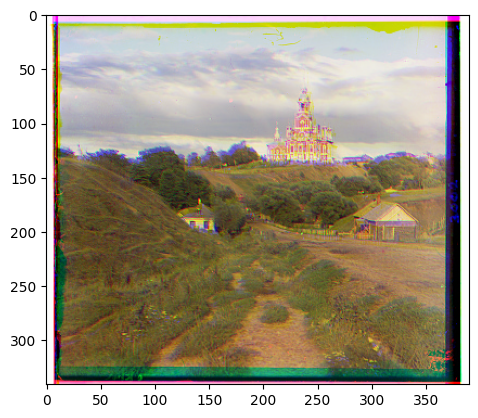

In [ ]:
# Choose metric: 'ncc' is robust; 'ssd' is simple.
metric = 'ncc'

# Big TIFFs → pyramid; small JPGs → single-scale is fine.
g_shift, img_g_aligned = align_pyramid_recursive(img_b_1, img_g_1, metric=metric)
r_shift, img_r_aligned = align_pyramid_recursive(img_b_1, img_r_1, metric=metric)

print("G shift (dy, dx):", g_shift)
print("R shift (dy, dx):", r_shift)

# Stack in RGB order for matplotlib
color = np.dstack([img_r_aligned, img_g_aligned, img_b_1])

plt.imshow(np.clip(color / 255.0, 0, 1))


G shift (dy, dx): (-3, 7)
R shift (dy, dx): (107, 17)


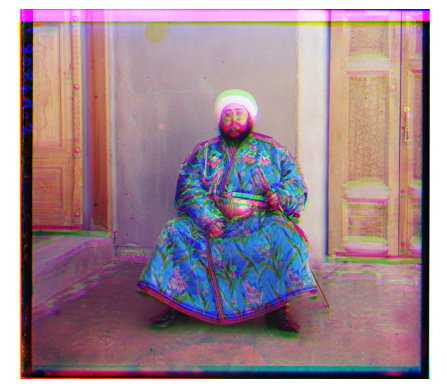

In [ ]:
metric = 'ncc'

g_shift, g_aligned = align_pyramid_recursive(img_b_tif_1, img_g_tif_1, metric=metric,
                                             coarse_search=8, refine_search=5)
r_shift, r_aligned = align_pyramid_recursive(img_b_tif_1, img_r_tif_1, metric=metric,
                                             coarse_search=8, refine_search=5)

print("G shift (dy, dx):", g_shift)
print("R shift (dy, dx):", r_shift)

# Stack RGB. If TIFF is 16-bit, scale for display.
rgb = np.dstack([r_aligned, g_aligned, img_b_tif_1])

# normalize for matplotlib:
if rgb.dtype == np.uint16 or rgb.max() > 1.5:   # likely 0..65535 or 0..255 floats
    rgb_vis = (rgb / rgb.max()).astype(np.float32)  # map to [0,1]
else:
    rgb_vis = np.clip(rgb, 0, 1).astype(np.float32)

plt.imshow(rgb_vis)
plt.axis('off'); plt.show()

# name of the input file
imname = 'cathedral.jpg'

# read in the image
im = cv2.imread(imname)

# convert to double (might want to do this later on to save memory)
#im = sk.img_as_float(im)

# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(np.int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)

### ag = align(g, b)
### ar = align(r, b)
# create a color image
im_out = np.dstack([ar, ag, b])

# save the image
fname = '/out_path/out_fname.jpg'
skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()